In [1]:
import os
import ssl
import urllib.request

import cv2
import numpy as np
import logging
import imageio
from skimage import io
from matplotlib import pyplot as plt

from fastapi import FastAPI, BackgroundTasks, Request
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import FileResponse, JSONResponse
from PIL import Image, ImageFilter

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import torch
from skimage import filters
import subprocess
from fastapi.middleware.cors import CORSMiddleware
from numpy import asarray
from PIL import Image, ImageOps

In [2]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [3]:
def get_best_mask(img: Image):
    array_image = np.asarray(img)

    predictor = SamPredictor(sam)
    predictor.set_image(array_image)

    input_point = np.array([[600, 400], [525, 600], [425, 600]])
    input_label = np.array([1, 1, 0])

    masks, scores, logits = predictor.predict(
    multimask_output=True,
    point_coords=input_point,
    point_labels=input_label,
    )
    masks.shape 
    best_mask = masks
    currentScore = 0

    for i, (mask, score) in enumerate(zip(masks, scores)):
        if (score > currentScore):
            currentScore = score
            best_mask = mask

    return best_mask

In [4]:
def cut_image(best_mask: Image):
    mask = Image.fromarray(best_mask)

    # Threshold and invert the colors (white will be transparent)
    mask = mask.point(lambda x: x > 100 and 255)

    # The size of the images must match before apply the mask
    img = ImageOps.fit(Image.open('pictures/woman.jpg'),mask.size)

    img.putalpha(mask) # Modifies the original image without return

    return img

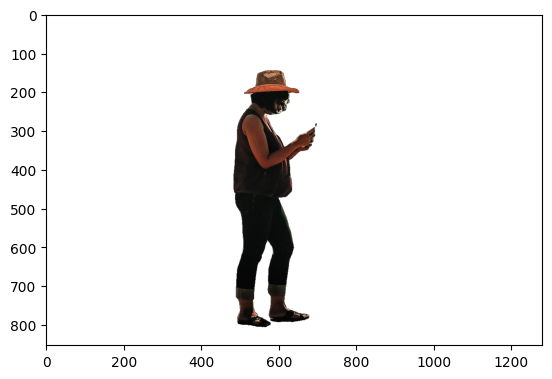

"from PIL import Image, ImageOps\nimg = cv2.cvtColor(cv2.imread('pictures/woman.jpg'), cv2.COLOR_BGR2RGB)\n\nbest_mask = get_best_mask(img)\n# Convert to grayscale\nimg = cut_image(best_mask)\n\nimg.save('result2.png')\nplt.imshow(img)\nplt.show()"

In [5]:
image = Image.open('pictures/woman.jpg')

img = cv2.cvtColor(cv2.imread('pictures/woman.jpg'), cv2.COLOR_BGR2RGB)


best_mask = get_best_mask(img)

# Assuming 'image' is your original image and 'segmentation_mask' is the mask image
binary_mask = np.where(best_mask > 0.5, 1, 0)

# Create a new image with the same size and RGBA format
new_image = np.zeros((img.shape[0], img.shape[1], 4))

# Use the binary mask to combine the original image and the transparency
new_image[..., :3] = img * binary_mask[..., np.newaxis]
new_image[..., 3] = binary_mask * 255


# Save the result as a PNG file
cv2.imwrite('new_dog_img.png', new_image)
new_image = new_image / 255

plt.imshow(new_image)
plt.show()

"""from PIL import Image, ImageOps
img = cv2.cvtColor(cv2.imread('pictures/woman.jpg'), cv2.COLOR_BGR2RGB)

best_mask = get_best_mask(img)
# Convert to grayscale
img = cut_image(best_mask)

img.save('result2.png')
plt.imshow(img)
plt.show()"""

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    i = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    i[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.99]])
        i[m] = color_mask
    ax.imshow(i)
    return i

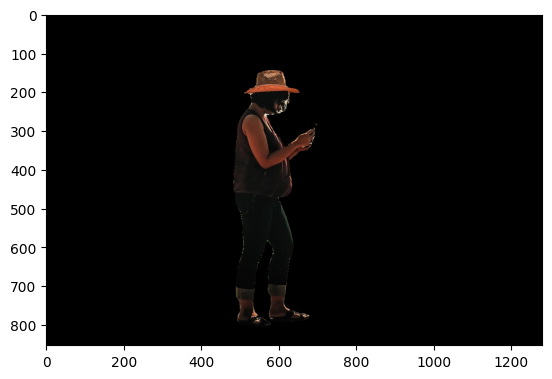

In [7]:
from numpy import asarray

mask_generator = SamAutomaticMaskGenerator(sam)
#img_float32 = np.float32(new_image)
#Image_try = Image.fromarray(img_float32)
#image2 = cv2.cvtColor(asarray(img), cv2.COLOR_BGR2RGB)
image2 = cv2.imread('new_dog_img.png')
plt.imshow(image2)
plt.show()


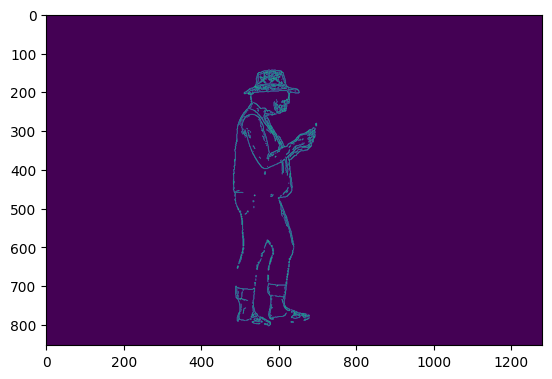

In [8]:
# Setting All parameters 
t_lower = 800  # Lower Threshold 
t_upper = 1000  # Upper threshold 
aperture_size = 5  # Aperture size 
  
# Applying the Canny Edge filter 
# with Custom Aperture Size 
c = cv2.Canny(image2, t_lower, t_upper,  
                 apertureSize=aperture_size) 
plt.imshow(c)
plt.show()

In [9]:
#nd_array_image = asarray(image2)

masks = mask_generator.generate(image2)
print(len(masks))
print(masks[0].keys())

15
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


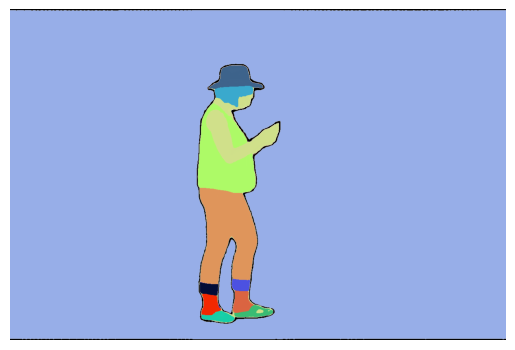

In [10]:
plt.imshow(image2)
anns = show_anns(masks)
plt.axis('off')
plt.show()          

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 3301, 'bbox': [528, 198, 99, 54], 'predicted_iou': 0.9450154304504395, 'point_coords': [[580.0, 199.921875]], 'stability_score': 0.9654659032821655, 'crop_box': [0, 0, 1280, 853]}
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 2245, 'bbox': [575, 725, 53, 57], 'predicted_iou': 0.9731078743934631,

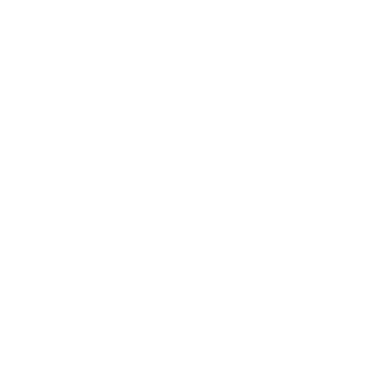

In [22]:
import random
chosen_masks = random.sample(masks, 2)
for m in chosen_masks:
    print(m)

plt.imshow(image2)
anns = show_anns(chosen_masks)
plt.axis('off')
plt.show()  

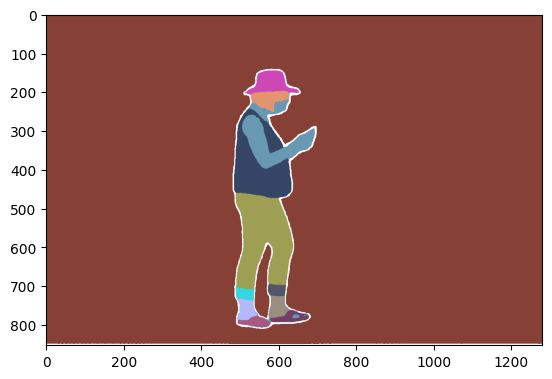

In [ ]:
data = 255 * anns # Now scale by 255
temp = data.astype(np.uint8)
#data = Image.fromarray(anns) 
plt.imshow(temp)
plt.show()
temp2 = temp

In [ ]:
# Assuming 'image' is your original image and 'segmentation_mask' is the mask image
binary_mask = np.where(best_mask > 0.5, 1, 0)

# Create a new image with the same size and RGBA format
new_image2 = np.zeros((temp2.shape[0], temp2.shape[1], 4))

# Use the binary mask to combine the original image and the transparency
new_image2[..., :3] = img * binary_mask[..., np.newaxis]
new_image2[..., 3] = binary_mask * 255


# Save the result as a PNG file
cv2.imwrite('new_dog_img2.png', new_image2)
new_image2 = new_image2 / 255

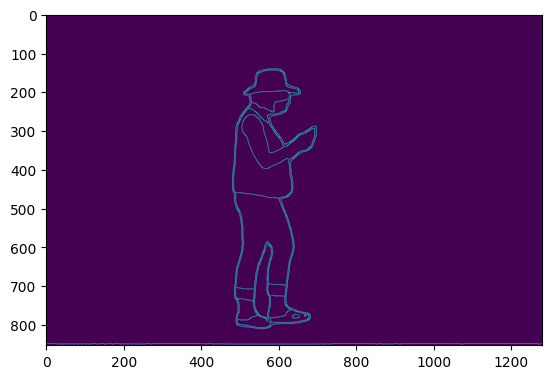

In [ ]:
# Setting All parameters 
t_lower = 100  # Lower Threshold 
t_upper = 200  # Upper threshold 
aperture_size = 5  # Aperture size 
  
# Applying the Canny Edge filter 
# with Custom Aperture Size 
c = cv2.Canny(temp, t_lower, t_upper,  
                 apertureSize=aperture_size) 
plt.imshow(c)
plt.show()

In [ ]:
CANNY_THRESH_1 = 1
CANNY_THRESH_2 = 600
MASK_COLOR = (0.0,0.0,1.0) # In BGR format

size = (6, 6)
shape = cv2.MORPH_RECT
#kernel = cv2.getStructuringElement(shape, size)
kernel = np.ones((3, 3), np.uint8) 
kernel1 = np.ones((4, 4), np.uint8) 
kernel2 = np.ones((3, 3), np.uint8) 

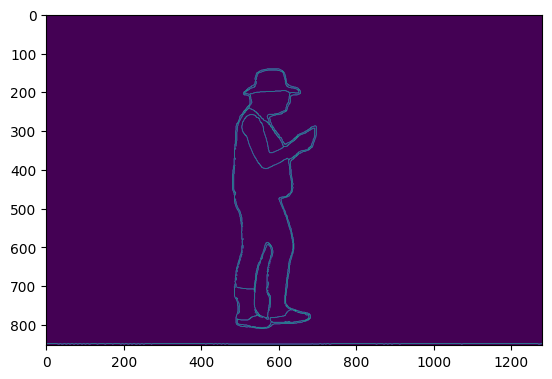

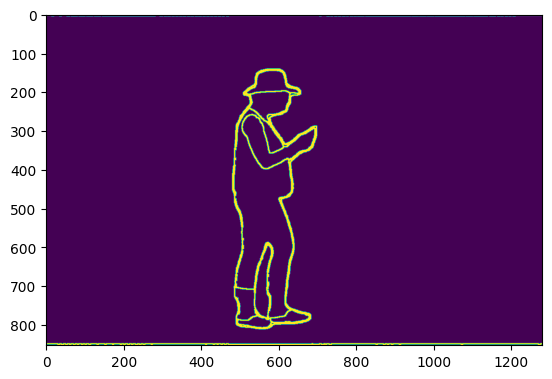

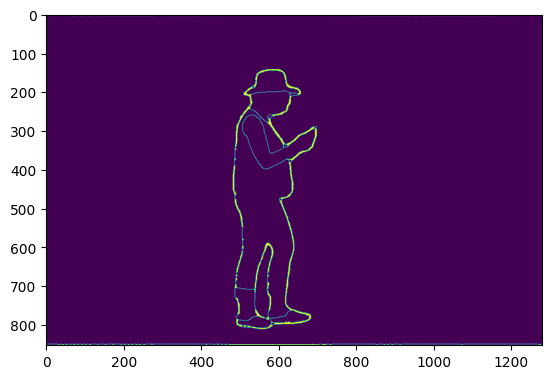

In [ ]:
# Color Space Conversion Codes
gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)

#-- Edge detection -------------------------------------------------------------------
# Edge Detection Algorithm
edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
plt.imshow(edges)
plt.show()
# enlarges the area of the object, highlighting features (existing image is taken)
edges = cv2.dilate(edges, kernel1)
plt.imshow(edges)
plt.show()
# Erode the boundaries of the foreground object
# Used to diminish the characteristics of an image.
edges = cv2.erode(edges, kernel1)

plt.imshow(edges)
plt.show()

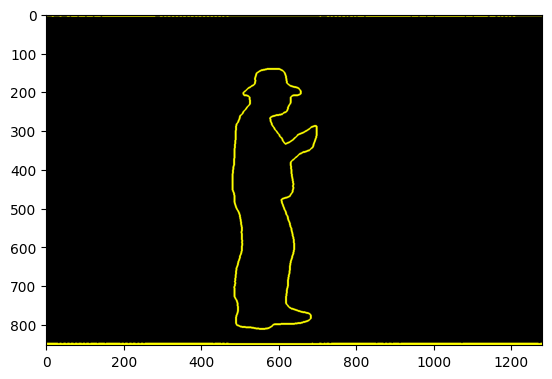

In [ ]:
# Assignment of pixel values in relation to the provided threshold
_, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(
    edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# show on screen (optional in jupiter)
%matplotlib inline
contours

drawing = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
CountersImg = cv2.drawContours(drawing, contours, -1, (255, 255, 0), 3)

# show on screen (optional in jupiter)
%matplotlib inline
plt.imshow(CountersImg)
plt.show()

ValueError: operands could not be broadcast together with shapes (853,1280,3) (853,1280,4) 

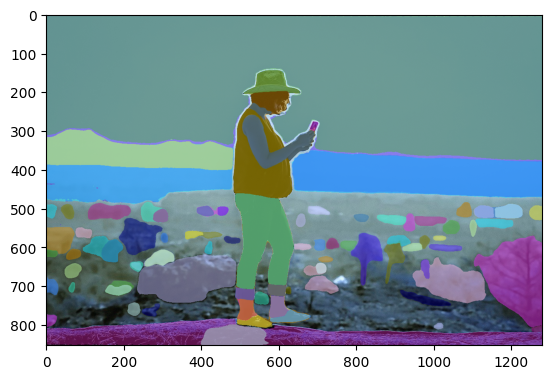

TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

<Figure size 640x480 with 0 Axes>

In [ ]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(masks)
annotated_image = mask_annotator.annotate(image2, detections)

plt.imshow(annotated_image)
plt.show()


x = plt.savefig()

plt.imshow(x, "x.png")
plt.show()

In [ ]:
i = 0
#image2 = cv2.cvtColor(asarray(img), cv2.COLOR_BGR2RGBA)
for m in masks:    
    edge_sobel = filters.sobel(m['segmentation'])
    cv2.cvtColor(asarray(edge_sobel), cv2.COLOR_BGR2RGBA)
    edge_img = Image.fromarray(edge_sobel)

    cv2.cvtColor(asarray(img), cv2.COLOR_BGR2RGBA)
    # Threshold and invert the colors (white will be transparent)
    mask = mask.point(lambda x: x > 100 and 255)

    # The size of the images must match before apply the mask
    img = ImageOps.fit(edge_img,mask.size)

    img.putalpha(mask) # Modifies the original image without return
    plt.imshow(edge_img)
    i = i + 1
plt.show()
#plt.imsave("test.png", edge_sobel)

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)
